# RNA Energy Barriers: Evaluation Functions

This notebook demonstrates how to use the evaluation functions to analyze and compare different path-finding algorithms for RNA energy barriers.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import RNA
import pandas as pd
import seaborn as sns

from src.rna_structure import RNAStructure
from src.path_finding import find_direct_path, find_best_indirect_path
import src.evolution as ev
import src.example_rna as ex
import src.evaluation as eval

%load_ext autoreload
%autoreload 2

# Enable nicer plots
plt.style.use('ggplot')
sns.set(style="whitegrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Basic Comparison of Path-Finding Methods

Let's start by comparing the different path-finding methods on the long example RNA sequence.

In [25]:
# Define the RNA sequence and structures
seq = ex.LONG_SEQ
start_struct = ex.LONG_START_STRUCT
end_struct = ex.LONG_END_STRUCT

print(f"Sequence: {seq}")
print(f"Start structure: {start_struct}")
print(f"End structure: {end_struct}")

Sequence: ACACGACCUCAUAUAAUCUUGGGAAUAUGGCCCAUAAGUUUCUACCCGGCAACCGUAAAUUGCCGGACUAUGCAGGGAAGUG
Start structure: ......................(....................)....(.............)...................
End structure: .(((..(((((((......((((.......))))...........(((((((.......)))))))..)))).)))...)))


Now, let's compare the different algorithms using our evaluation functions:

Base pair distance between structures: 21
Attempt 1: path length = 30, energy barrier = 0.00
New best barrier: 0.00
Attempt 2: path length = 1174, energy barrier = 299992.59
Attempt 3: path length = 86, energy barrier = 2.60

Generation 10:
{'structure': '....................((........)).............(((((((.......)))))))................', 'distance': 24, 'highest_energy': 0, 'path': ['......................(....................)....(.............)...................', '................................................(.............)...................', '...............................................((.............))..................', '...............................................(((...........)))..................', '..............................................((((...........)))).................', '.............................................(((((...........)))))................', '.............................................((((((.........))))))................', '..........

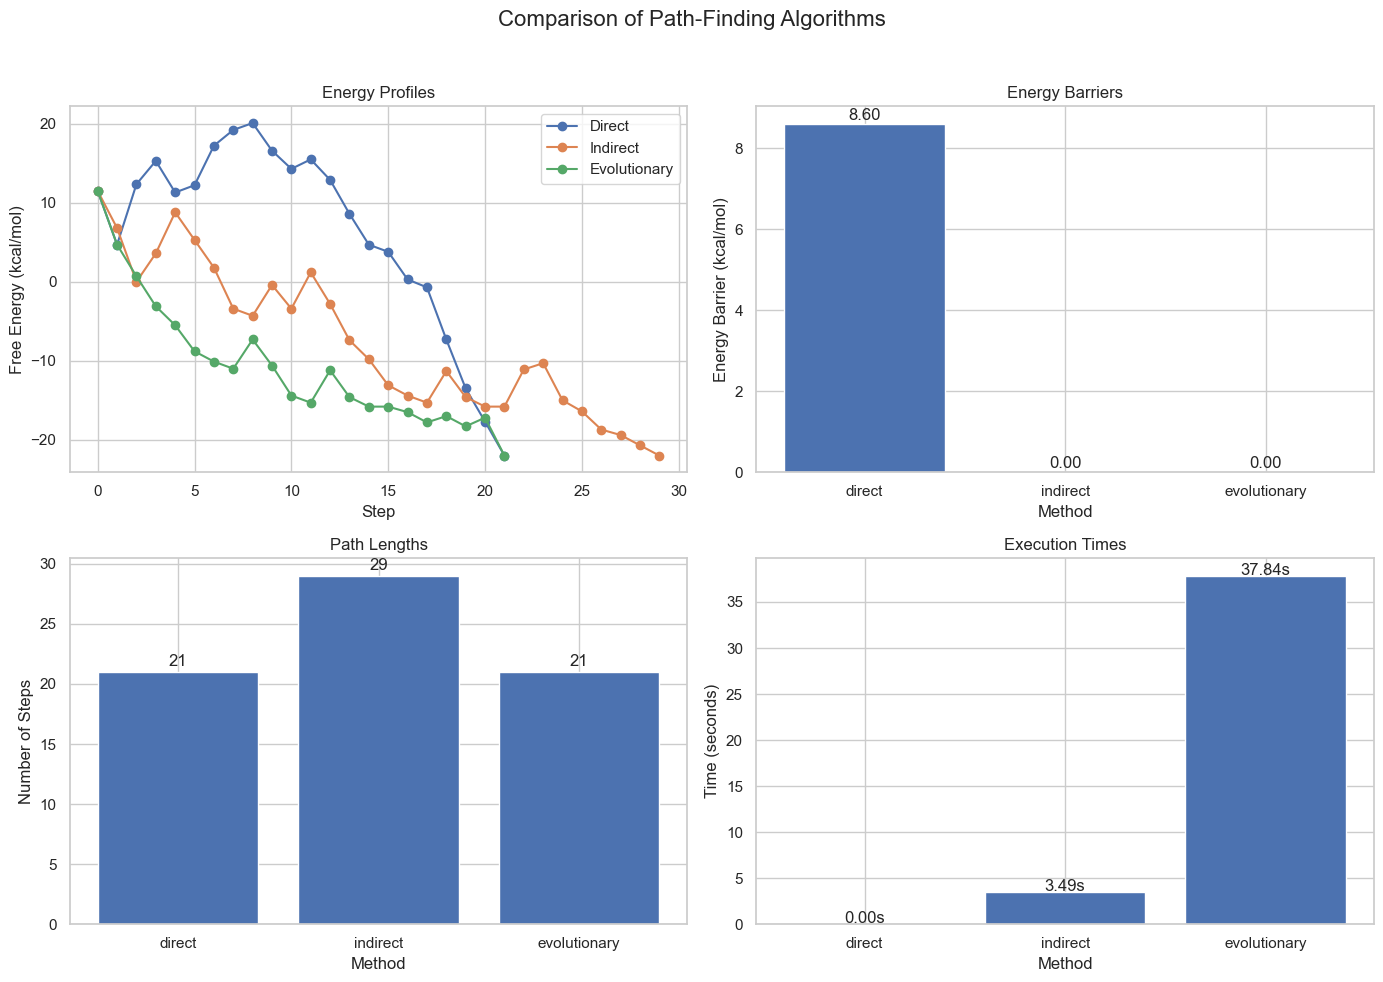

In [26]:
# Compare algorithms
results = eval.compare_algorithms(
    seq, 
    start_struct, 
    end_struct, 
    methods=['direct', 'indirect', 'evolutionary'],
    evolutionary_params={'N': 100, 'max_steps': 100},
    indirect_attempts=3
)

# Plot comparison
eval.plot_comparison(results, figsize=(14, 10))

Let's examine the transition types in each path:

In [27]:
# Analyze transition types
transition_df = eval.transition_analysis(results)
transition_df

,Method,Add Transitions,Remove Transitions,Both Transitions,Total Transitions,Add %,Remove %,Both %
0,Direct,20,1,0,21,95.238095,4.761905,0.0
1,Indirect,24,5,0,29,82.758621,17.241379,0.0
2,Evolutionary,20,1,0,21,95.238095,4.761905,0.0


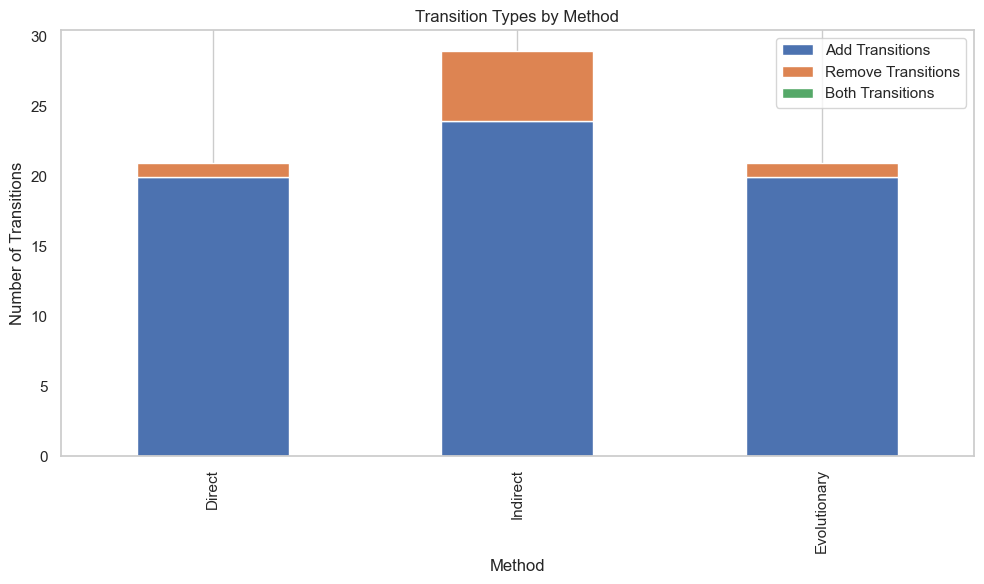

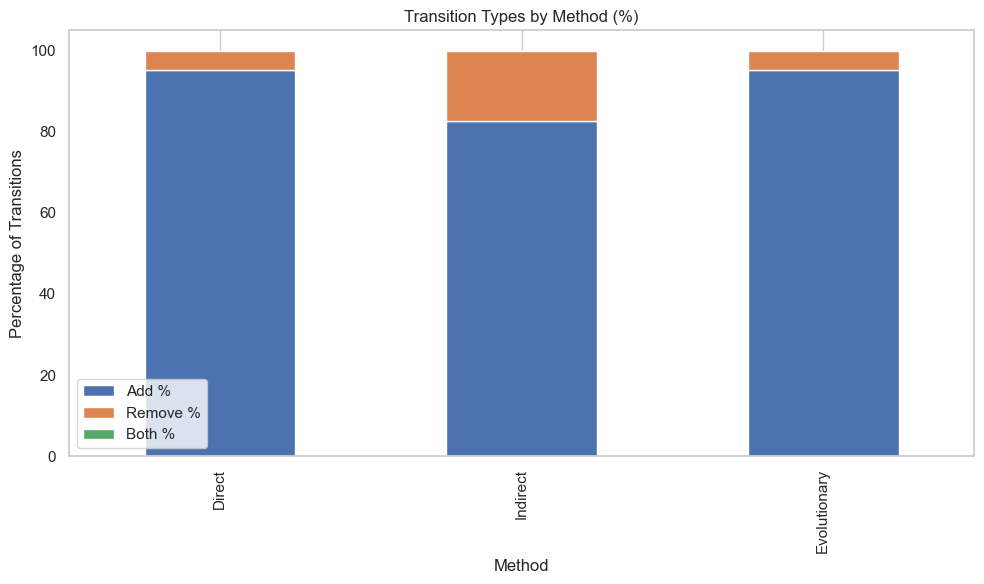

In [28]:
# Visualize transition types
fig, ax = plt.subplots(figsize=(10, 6))
transition_types = transition_df[['Method', 'Add Transitions', 'Remove Transitions', 'Both Transitions']]
transition_types.set_index('Method').plot(kind='bar', stacked=True, ax=ax)
plt.title('Transition Types by Method')
plt.ylabel('Number of Transitions')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Visualize transition percentages
fig, ax = plt.subplots(figsize=(10, 6))
transition_pct = transition_df[['Method', 'Add %', 'Remove %', 'Both %']]
transition_pct.set_index('Method').plot(kind='bar', stacked=True, ax=ax)
plt.title('Transition Types by Method (%)')
plt.ylabel('Percentage of Transitions')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## 2. Energy Landscape Visualization

Let's visualize the energy landscape and the paths taken by different algorithms:

In [29]:
# Collect all structures from all paths
all_structures = set()
paths = {}

for method, metrics in results.items():
    path = []
    for i, struct in enumerate(metrics['transitions']):
        if i == 0:
            path.append(struct[0])
        path.append(struct[1])
        all_structures.add(struct[0])
        all_structures.add(struct[1])
    paths[method] = path

all_structures = list(all_structures)

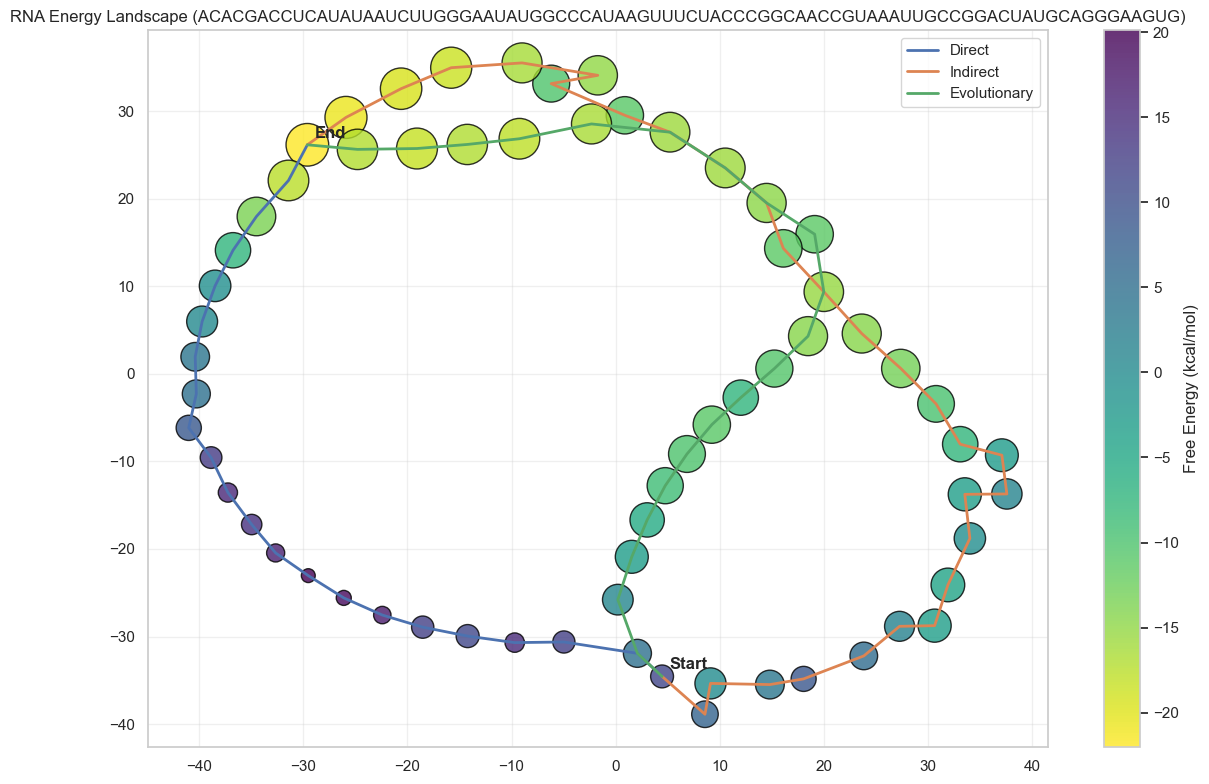

In [30]:
# Generate labels for start and end structures
labels = []
for struct in all_structures:
    if struct == start_struct:
        labels.append('Start')
    elif struct == end_struct:
        labels.append('End')
    else:
        labels.append('')

# Visualize the energy landscape
eval.energy_landscape_visualization(
    seq, 
    all_structures, 
    title=f"RNA Energy Landscape ({seq})", 
    figsize=(12, 8),
    point_labels=labels,
    highlight_paths=paths
)

## 3. Analyzing Multiple RNA Sequences

Let's analyze both the short and long RNA examples:

In [31]:
# Define sequences, start structures, and end structures
sequences = [ex.SHORT_SEQ, ex.LONG_SEQ]
start_structs = [ex.SHORT_START_STRUCT, ex.LONG_START_STRUCT]
end_structs = [ex.SHORT_END_STRUCT, ex.LONG_END_STRUCT]
sequence_names = ["Short RNA", "Long RNA"]

# Run batch analysis
batch_results = eval.batch_analysis(
    sequences, 
    start_structs, 
    end_structs, 
    sequence_names=sequence_names,
    methods=['direct', 'indirect']
)

# Display batch results
batch_results

Analyzing Short RNA...
Base pair distance between structures: 4
Attempt 1: path length = 9, energy barrier = 0.00
New best barrier: 0.00
Attempt 2: path length = 17, energy barrier = 2.50
Attempt 3: path length = 287, energy barrier = 3.00
Analyzing Long RNA...
Base pair distance between structures: 21
Attempt 1: path length = 26, energy barrier = 1.30
New best barrier: 1.30
Attempt 2: path length = 342, energy barrier = 199987.59
Attempt 3: path length = 458, energy barrier = 199973.59
Attempt 4: path length = 38, energy barrier = 0.00
New best barrier: 0.00
Attempt 5: path length = 812, energy barrier = 299985.91


,Sequence,Length,Method,Energy Barrier,Path Length,Execution Time (s),Initial Energy,Final Energy,Average Energy
0,Short RNA,11,Direct,0.0,4,0.000000,6.4,2.5,3.400000
1,Short RNA,11,Indirect,0.0,8,0.070835,6.4,2.5,2.388889
2,Long RNA,82,Direct,8.6,21,0.000000,11.5,-22.0,6.339545
3,Long RNA,82,Indirect,0.0,37,8.650129,11.5,-22.0,-7.381842


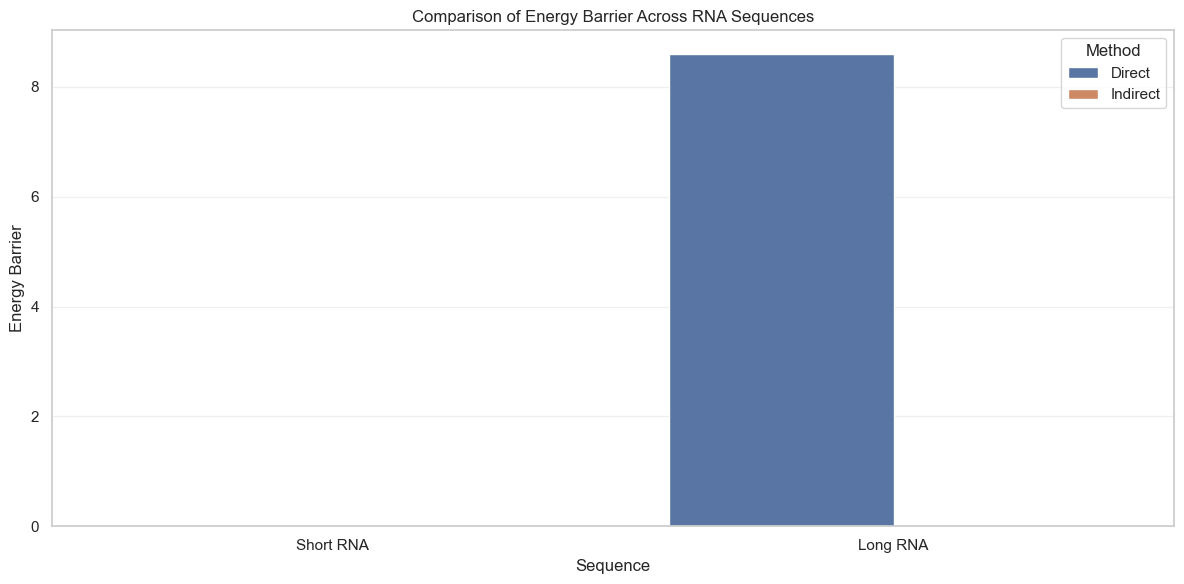

In [32]:
# Compare energy barriers across sequences and methods
eval.plot_sequence_comparison(batch_results, metric='Energy Barrier')

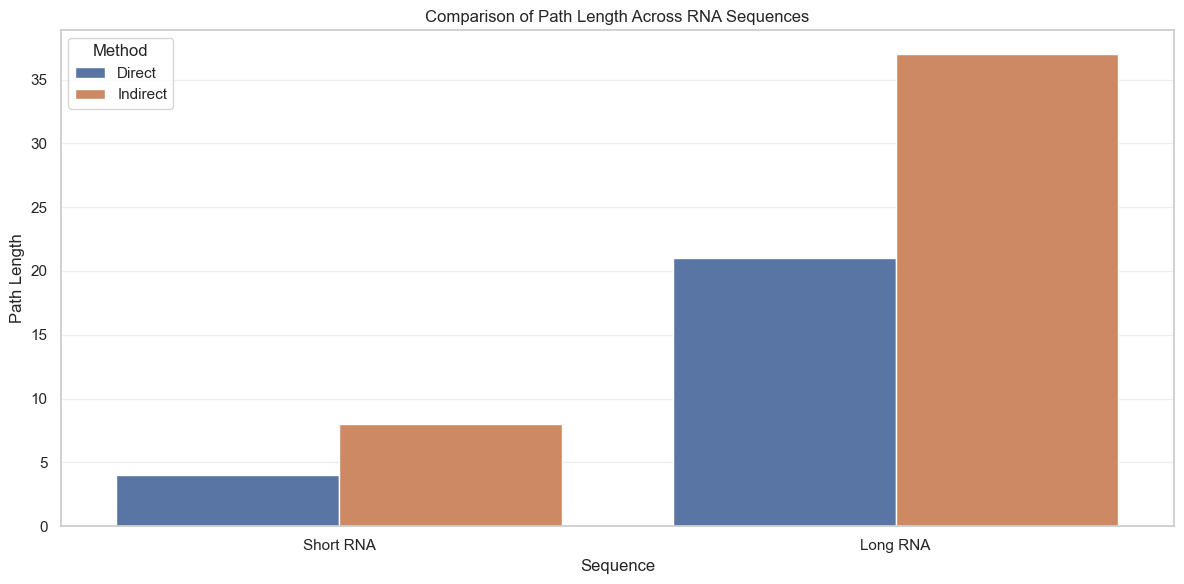

In [33]:
# Compare path lengths across sequences and methods
eval.plot_sequence_comparison(batch_results, metric='Path Length')

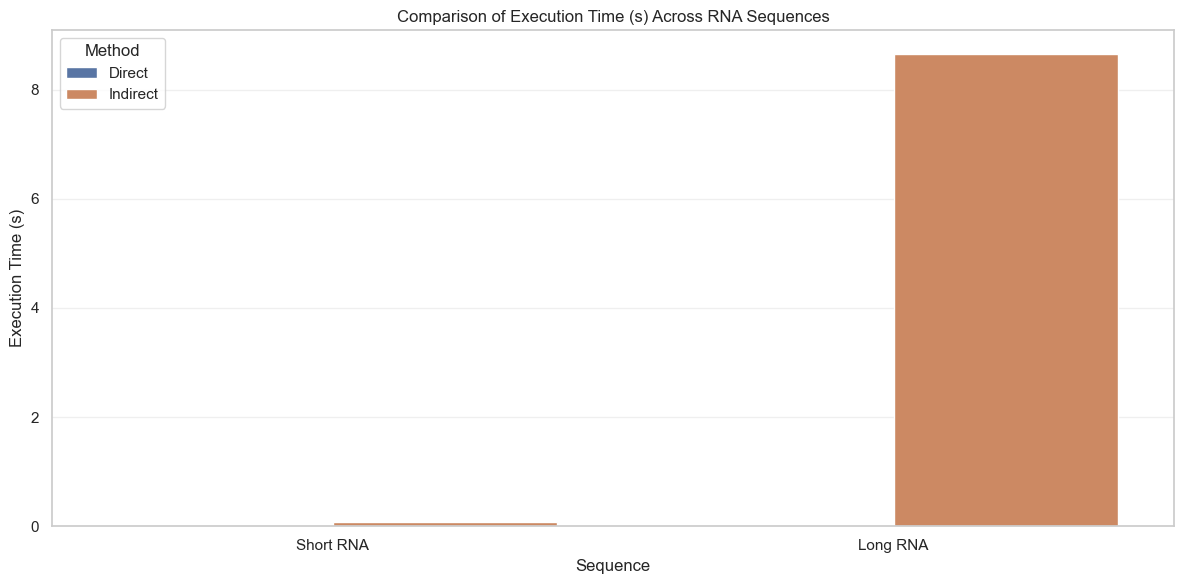

In [34]:
# Compare execution times across sequences and methods
eval.plot_sequence_comparison(batch_results, metric='Execution Time (s)')

## 4. Correlation Analysis

Let's analyze the correlations between sequence properties and algorithm performance:

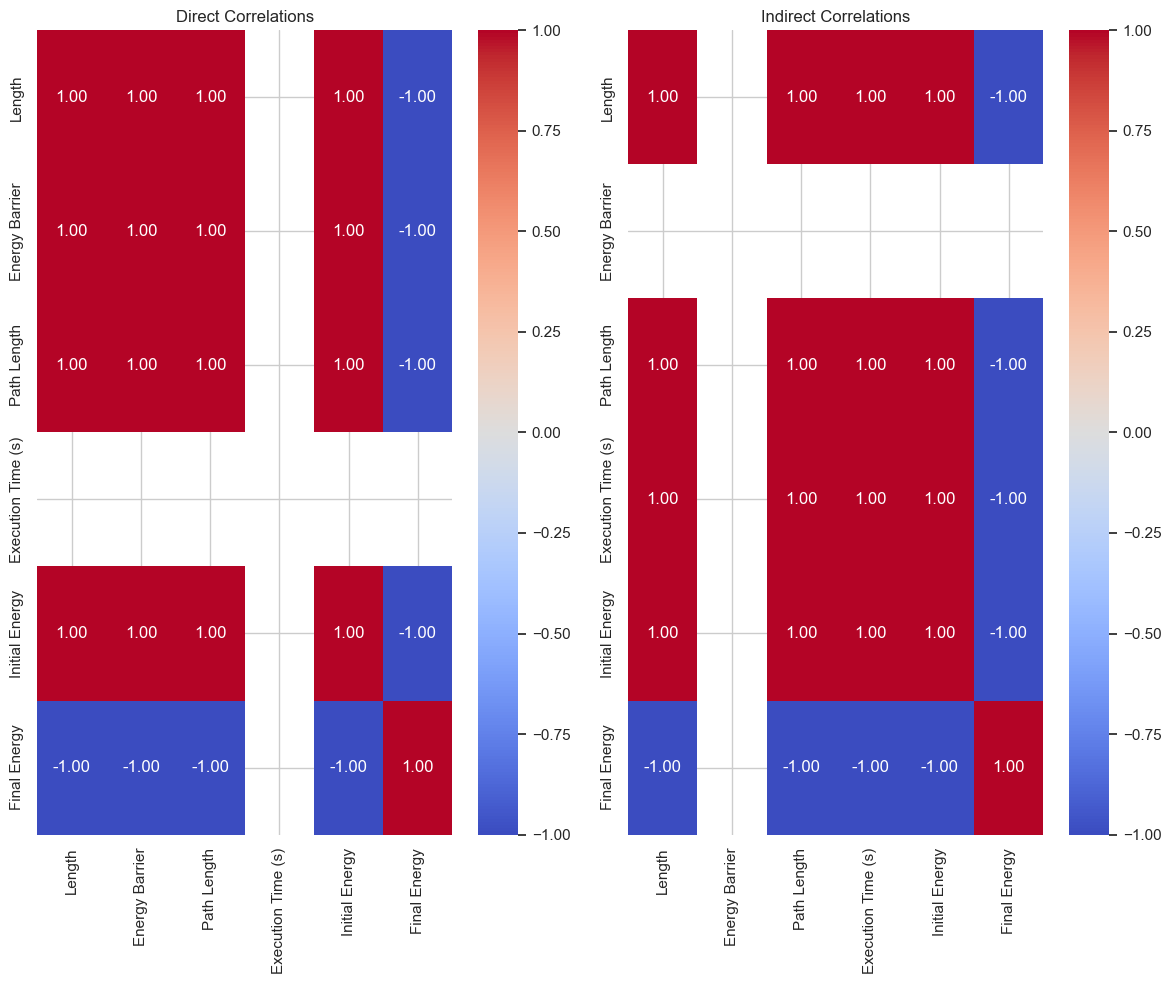

In [35]:
# Perform correlation analysis
correlation_results = eval.correlation_analysis(batch_results)

# Plot correlation matrix
eval.plot_correlation_matrix(correlation_results)

## 5. Success Rate Analysis

Let's analyze the success rates of different algorithms based on custom criteria:

In [36]:
# Analyze success rates with energy threshold and time limit
success_df = eval.analyze_success_rates(
    ex.LONG_SEQ,
    ex.LONG_START_STRUCT,
    ex.LONG_END_STRUCT,
    num_trials=5,
    methods=['direct', 'indirect', 'evolutionary'],
    energy_threshold=3.0,
)

# Display success rates
success_df

Trial 1/5
Base pair distance between structures: 21
Attempt 1: path length = 26, energy barrier = 0.00
New best barrier: 0.00
Attempt 2: path length = 300, energy barrier = 199999.30
Attempt 3: path length = 54, energy barrier = 0.00
Attempt 4: path length = 1214, energy barrier = 399981.38
Attempt 5: path length = 1088, energy barrier = 399986.09

Generation 10:
{'structure': '.....................((........))............(((((((.......)))))))................', 'distance': 24, 'highest_energy': 0, 'path': ['......................(....................)....(.............)...................', '................................................(.............)...................', '................................................((...........))...................', '...............................................(((...........)))..................', '...............................................((((.........))))..................', '..............................................(((((......

,Method,Success Count,Total Trials,Success Rate (%),Avg Energy Barrier,Avg Path Length,Avg Execution Time (s)
0,Direct,0,5,0.0,8.6,21.0,0.000202
1,Indirect,5,5,100.0,0.0,32.2,7.424966
2,Evolutionary,5,5,100.0,0.0,26.6,43.983470


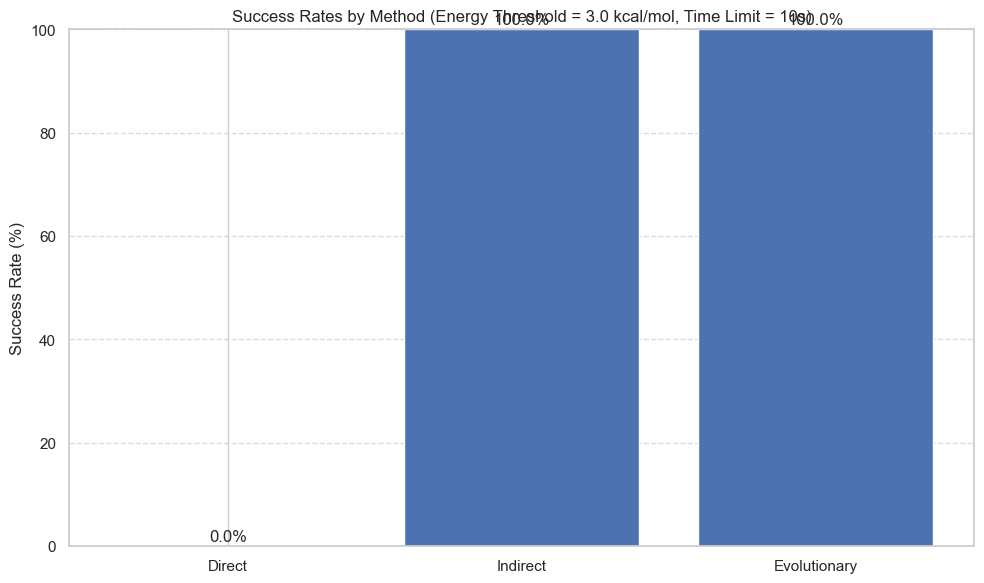

In [37]:
# Plot success rates
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(success_df['Method'], success_df['Success Rate (%)'])
ax.set_title('Success Rates by Method (Energy Threshold = 3.0 kcal/mol, Time Limit = 10s)')
ax.set_ylabel('Success Rate (%)')
ax.set_ylim(0, 100)
for i, v in enumerate(success_df['Success Rate (%)']):
    ax.text(i, v + 1, f"{v:.1f}%", ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 6. Advanced Analysis: Comparing Parameter Settings

Let's analyze how different parameter settings affect the performance of the evolutionary algorithm:

In [38]:
# Define parameter combinations to test
parameter_combinations = [
    {'N': 50, 'max_steps': 50, 'alpha': 0.7, 'beta': 0},
    {'N': 50, 'max_steps': 100, 'alpha': 0.7, 'beta': 0},
    {'N': 100, 'max_steps': 50, 'alpha': 0.7, 'beta': 0},
    {'N': 100, 'max_steps': 100, 'alpha': 0.7, 'beta': 0},
    {'N': 100, 'max_steps': 100, 'alpha': 0.5, 'beta': 0},
    {'N': 100, 'max_steps': 100, 'alpha': 0.7, 'beta': 0.5}
]

# Run analysis for each parameter combination
param_results = []

for params in parameter_combinations:
    # Create a unique name for this parameter combination
    param_name = f"Evo (N={params['N']}, steps={params['max_steps']}, α={params['alpha']}, β={params['beta']})"
    
    # Run the evolutionary algorithm with these parameters
    start_struct = RNAStructure(ex.LONG_SEQ, structure=ex.LONG_START_STRUCT)
    end_struct = RNAStructure(ex.LONG_SEQ, structure=ex.LONG_END_STRUCT)
    
    best, steps = ev.best_folding(
        ex.LONG_SEQ, 
        ex.LONG_START_STRUCT, 
        ex.LONG_END_STRUCT, 
        N=params['N'], 
        max_steps=params['max_steps'], 
        alpha=params['alpha'],
        beta=params['beta']
    )
    
    # Calculate metrics
    metrics = eval.calculate_path_metrics(ex.LONG_SEQ, best['path'])
    
    param_results.append({
        'Parameter Set': param_name,
        'Energy Barrier': metrics['energy_barrier'],
        'Path Length': metrics['path_length'],
        'Average Energy': metrics['average_energy'],
        'Final Energy': metrics['final_energy'],
        'Max Energy': metrics['max_energy'],
        'Generation Steps': steps
    })

# Create DataFrame
param_df = pd.DataFrame(param_results)
param_df


Generation 10:
{'structure': '...(.................((........))............(((((((.......)))))))........).......', 'distance': 22, 'highest_energy': 0, 'path': ['......................(....................)....(.............)...................', '................................................(.............)...................', '................................................((...........))...................', '...............................................(((...........)))..................', '..............................................((((...........)))).................', '.............................................(((((...........)))))................', '.............................................((((((.........))))))................', '......................(........).............((((((.........))))))................', '.....................((........))............((((((.........))))))................', '.....................((........))............(((((((.......))))

,Parameter Set,Energy Barrier,Path Length,Average Energy,Final Energy,Max Energy,Generation Steps
0,"Evo (N=50, steps=50, α=0.7, β=0)",0.0,26,-10.844444,-16.299999,11.5,50
1,"Evo (N=50, steps=100, α=0.7, β=0)",0.0,27,-10.321429,-22.000000,11.5,38
2,"Evo (N=100, steps=50, α=0.7, β=0)",0.0,23,-11.237500,-22.000000,11.5,32
3,"Evo (N=100, steps=100, α=0.7, β=0)",0.0,21,-10.768182,-22.000000,11.5,29
4,"Evo (N=100, steps=100, α=0.5, β=0)",0.0,27,-11.942857,-20.600000,11.5,100
5,"Evo (N=100, steps=100, α=0.7, β=0.5)",0.0,21,-10.804545,-22.000000,11.5,23


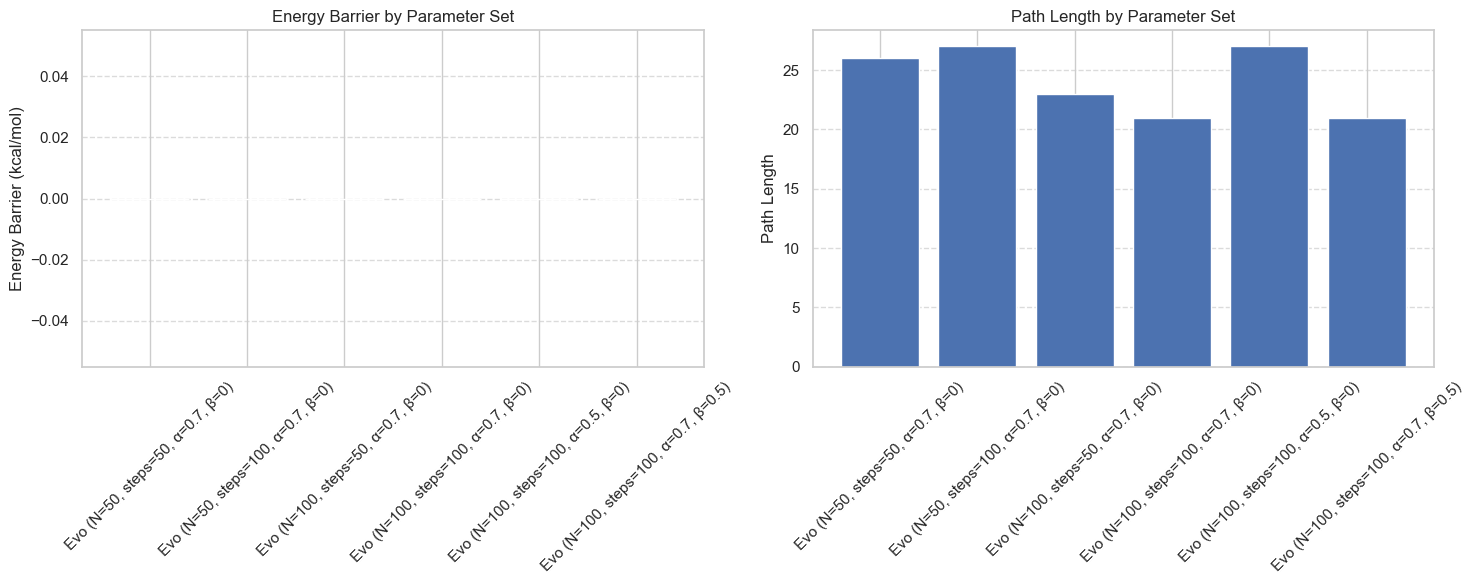

In [39]:
# Plot parameter comparison
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot energy barriers
axs[0].bar(param_df['Parameter Set'], param_df['Energy Barrier'])
axs[0].set_title('Energy Barrier by Parameter Set')
axs[0].set_ylabel('Energy Barrier (kcal/mol)')
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot path lengths
axs[1].bar(param_df['Parameter Set'], param_df['Path Length'])
axs[1].set_title('Path Length by Parameter Set')
axs[1].set_ylabel('Path Length')
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

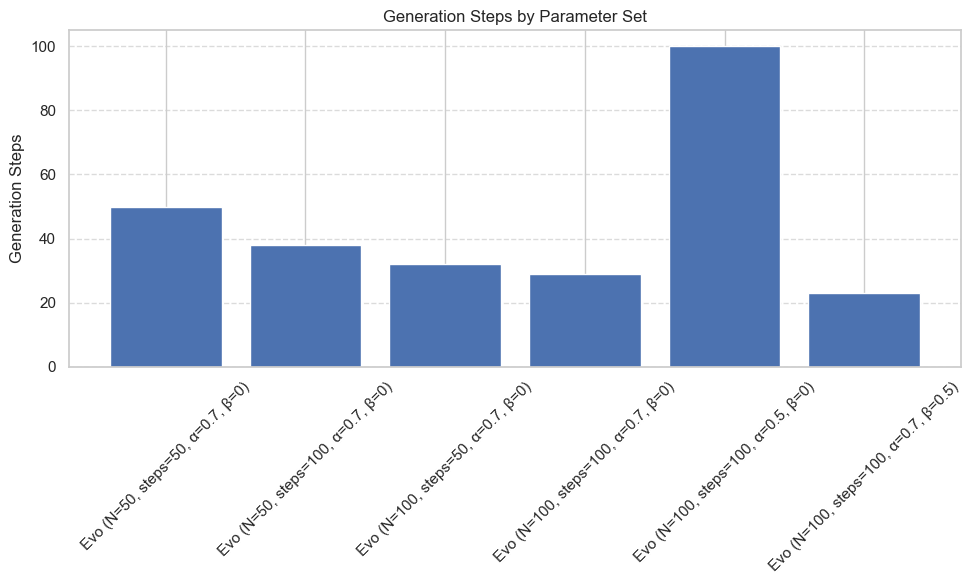

In [40]:
# Plot generation steps
plt.figure(figsize=(10, 6))
plt.bar(param_df['Parameter Set'], param_df['Generation Steps'])
plt.title('Generation Steps by Parameter Set')
plt.ylabel('Generation Steps')
plt.tick_params(axis='x', rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 7. Conclusion

In this notebook, we demonstrated various evaluation functions for analyzing RNA energy barriers and comparing different path-finding algorithms. These functions provide insights into:

1. Comparing energy barriers, path lengths, and execution times of different methods
2. Analyzing transition types in folding paths
3. Visualizing the energy landscape and paths
4. Batch analysis of multiple RNA sequences
5. Correlation analysis between sequence properties and algorithm performance
6. Success rate analysis based on custom criteria
7. Parameter sensitivity analysis for the evolutionary algorithm

These evaluation functions can be applied to different RNA folding problems to gain insights into the performance and behavior of various path-finding algorithms.